In [59]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# Import Libraries

In [60]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers , activations , models , preprocessing , utils
import pandas as pd
from tensorflow.keras.layers import Input, Embedding,Dense,  LSTM
from tensorflow.keras.models import load_model
import string
import pickle
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import statistics
import math



In [61]:
!pip install datasets==1.18.1
from datasets import load_dataset
dataset = load_dataset("cfilt/iitb-english-hindi")

Using custom data configuration cfilt--iitb-english-hindi-911387c6837f8b91
Reusing dataset parquet (/Users/learn/.cache/huggingface/datasets/parquet/cfilt--iitb-english-hindi-911387c6837f8b91/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121)


  0%|          | 0/3 [00:00<?, ?it/s]

## Preparing Data

### TASK: Create Encder-Decoder LSTM model to convert Hindi sentences to English sentences.  

### 2. Read Data : IIT Bombay 

### Text Processing

In [62]:
def removePunctuation(lines):
    # Remove punctuation
    lines[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in lines[:,0]]
    lines[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in lines[:,1]]
    return lines

In [63]:
def toLowercase(lines):
    for i in range(len(lines)):
        lines[i,0] = lines[i,0].lower()   
        lines[i,1] = lines[i,1].lower()
    return lines

In [64]:
from numpy import array
def createDataset(dataset, data_size,type):
    pairs=[] 
    for translation_pair in dataset[type]["translation"][:data_size]:
        source_sentence = translation_pair["hi"]
        target_sentence = translation_pair["en"]
        pairs.append([source_sentence, target_sentence])
    pairs = array(pairs)
    pairs= toLowercase(pairs)
    pairs=removePunctuation(pairs)

    lines= pd.DataFrame(columns=[ "hindi","eng"], data=pairs)
    lines= lines[:data_size]
   
    return lines
      


### 3) Preparing input data for the Encoder ( `encoder_input_data` )

In [65]:
def createInputDataForEncoder(lines):
    hindi_lines = list()
    for line in lines.hindi:
        hindi_lines.append( line ) 
        
    tokenizer = preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts( hindi_lines ) 
    tokenized_hindi_lines = tokenizer.texts_to_sequences( hindi_lines ) 
    length_list = list()

    for token_seq in tokenized_hindi_lines:
        length_list.append( len( token_seq ))

    # max_input_length = np.array( length_list ).max()
    max_input_length = math.floor(statistics.mode(length_list))

    padded_hindi_lines = preprocessing.sequence.pad_sequences( tokenized_hindi_lines , maxlen=max_input_length , padding='post' )
    encoder_input_data = np.array( padded_hindi_lines )
   
    hindi_word_dict = tokenizer.word_index
    num_hindi_tokens = len( hindi_word_dict )+1
    # print("Hindi Dictionary" ,hindi_word_dict  )
    return max_input_length, num_hindi_tokens, encoder_input_data, hindi_word_dict
   


                

### Create Dataset for Decoder

### 4) Preparing input data for the Decoder ( `decoder_input_data` )

In [66]:

def createInputDataForDecoder(lines):
    eng_lines = list()
    for line in lines.eng:
        eng_lines.append( '<START> ' + line + ' <END>' )  

    tokenizer = preprocessing.text.Tokenizer(oov_token=1)
    tokenizer.fit_on_texts( eng_lines ) 
    tokenized_eng_lines = tokenizer.texts_to_sequences( eng_lines ) 

    length_list = list()
    for token_seq in tokenized_eng_lines:
        length_list.append( len( token_seq ))
    # max_output_length = np.array( length_list ).max()
    max_output_length = math.floor(statistics.mode(length_list))
    print( 'English max length is {}'.format( max_output_length ))

    padded_eng_lines = preprocessing.sequence.pad_sequences( tokenized_eng_lines , maxlen=max_output_length, padding='post' )
    decoder_input_data = np.array( padded_eng_lines  )
    print( 'Decoder input data shape -> {}'.format( decoder_input_data.shape ))

    eng_word_dict = tokenizer.word_index
    num_eng_tokens = len( eng_word_dict )+1
    print( 'Number of English tokens = {}'.format( num_eng_tokens))

    return max_output_length, num_eng_tokens, decoder_input_data, eng_word_dict, tokenized_eng_lines

### 5) Preparing target data for the Decoder ( decoder_target_data ) 

In [67]:
def createDecoderTargetData(tokenized_eng_lines, max_output_length, num_eng_tokens):
    decoder_target_data = list()
    for token_seq in tokenized_eng_lines:
        decoder_target_data.append( token_seq[ 1 : ] ) 
        
    padded_eng_lines = preprocessing.sequence.pad_sequences( decoder_target_data , maxlen=max_output_length, padding='post' )
    onehot_eng_lines = utils.to_categorical( padded_eng_lines , num_eng_tokens )
    decoder_target_data = np.array( onehot_eng_lines )
    print( 'Decoder target data shape -> {}'.format( decoder_target_data.shape ))
    return decoder_target_data

### 1) Defining the Encoder-Decoder model

In [68]:

def create_encoder_decoder(encoder_inputs,encoder_states,decoder_lstm,decoder_embedding,decoder_dense,decoder_inputs):
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 256,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 256 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

In [69]:
def createEncoderDecoderModel(max_input_length, max_output_length, num_hindi_tokens, num_eng_tokens):
    encoder_inputs = Input(shape=( max_input_length ,  ))
    encoder_embedding = Embedding( num_hindi_tokens, 256 , mask_zero=True ) (encoder_inputs)
    encoder_outputs , state_h , state_c = LSTM( 256 , return_state=True , recurrent_dropout=0.2 , dropout=0.2 )( encoder_embedding )
    encoder_states = [ state_h , state_c ]

    decoder_inputs = Input(shape=( max_output_length , ))
    decoder_embedding = Embedding( num_eng_tokens, 256 , mask_zero=True) (decoder_inputs)
    decoder_lstm = LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
    decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
    decoder_dense = Dense( num_eng_tokens , activation=tf.keras.activations.softmax ) 
    output = decoder_dense ( decoder_outputs )

    model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy')
    encoder_model , decoder_model= create_encoder_decoder(encoder_inputs,encoder_states,decoder_lstm,decoder_embedding,decoder_dense,decoder_inputs)
    return model ,encoder_model , decoder_model



### Save Encoder And Decoder Parameters

In [70]:

def save_models_and_parameters(lines,model,encoder_model , decoder_model, max_input_length, num_hindi_tokens, hindi_word_dict,max_output_length,num_eng_tokens,eng_word_dict):
    model_name = str(lines.count().eng)
    !mkdir $model_name
    !ls
    model.save( model_name+'/model.h5' ) 
    # save encoder model
    encoder_model.save( model_name+'/enc_model.h5' ) 
    # save decoder model
    decoder_model.save( model_name+'/dec_model.h5' ) 

    # encoder parameters
    encoder_parameters={
        'max_encoder_seq_length': max_input_length,
        'num_encoder_tokens': num_hindi_tokens,
        
    
    }
    encoder_dictionary=  hindi_word_dict


    # decoder parameters
    decoder_parameters={
        'max_decoder_seq_length':  max_output_length,
        'num_decoder_tokens': num_eng_tokens,

    }

    decoder_dictionary=  eng_word_dict
    parameters=model_name+"/parameters/"
    dictionaries=model_name+"/dictionaries/"
    !mkdir $parameters
    !mkdir $dictionaries
    paramters_path=parameters
    dictionaries_path=dictionaries

    # save encoder parameter
    with open(paramters_path+'encoder_parameters.pickle', 'wb') as handle:
        pickle.dump(encoder_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save encoder dictionary
    with open(dictionaries_path+'encoder_dictionary.pickle', 'wb') as handle:
        pickle.dump(encoder_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save encoder parameter
    with open(paramters_path+'decoder_parameters.pickle', 'wb') as handle:
        pickle.dump(decoder_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save encoder parameter
    with open(dictionaries_path+'decoder_dictionary.pickle', 'wb') as handle:
        pickle.dump(decoder_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)    
    print("Model ",model_name," saved successfully!")    




### Handle Helper Functions 

In [71]:
!ls

1000                     assignment.ipynb
2000                     my_nmt_model_min_loss.h5


In [72]:
import os
import sys

def handle_helper_functions():
    print(sys.path)
    directory_path = os.path.abspath(os.path.join('../../helper'))
    if directory_path not in sys.path:
        sys.path.append(directory_path)    

    translation_path=os.path.abspath(os.path.join('../../utils')) 
    if translation_path not in sys.path:
        sys.path.append(translation_path)    #/Users/learn/Desktop/Projects/machine-translation/test/helper
      #/Users/learn/Desktop/Projects/machine-translation/utils   
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/test/helper')                                         #/Users/learn/Desktop/Projects/machine-translation/utils   
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/utils')
    print(sys.path)
    

handle_helper_functions()

['/Users/learn/Desktop/Projects/machine-translation/tutorial', '/Users/learn/.vscode/extensions/ms-toolsai.jupyter-2022.9.1303220346/pythonFiles', '/Users/learn/.vscode/extensions/ms-toolsai.jupyter-2022.9.1303220346/pythonFiles/lib/python', '/Users/learn/Desktop/Projects/machine-translation/.env/lib/python39.zip', '/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9', '/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/lib-dynload', '', '/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages', '/Users/learn/.cache/huggingface/modules', '/Users/learn/Desktop/Projects/helper', '/Users/learn/Desktop/Projects/utils', '/Users/learn/Desktop/Projects/machine-translation/test/helper', '/Users/learn/Desktop/Projects/machine-translation/utils', '/Users/learn/Desktop/Projects/machine-translation/test/helper', '/Users/learn/Desktop/Projects/machine-translation/utils']
['/Users/learn/Desktop/Projects/machine-translation/tutorial', '/Us

In [73]:
from nltk.translate.bleu_score import sentence_bleu
import tensorflow_text as text
from scoreTest import get_cosine_val, get_BLEU_score, get_ROUGE_score
from translate import  translate_sentence

### Get Summary Statistics For Every Model

In [74]:
def get_model_statistics_summary(model_path,path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary, encoderPath, decoderPath, lines ):

################################## START  ##################################
    reconstructed_model = keras.models.load_model(model_path)
    plot_model(reconstructed_model, to_file='modelsummary.png', show_shapes=True, show_layer_names=True)
    reconstructed_model.summary()


    ## Load Dictionaries and Parameters 
    path_encoder_parameters= path_encoder_parameters
    path_encoder_dictionary= path_encoder_dictionary
    path_decoder_parameters= path_decoder_parameters
    path_decoder_dictionary= path_decoder_dictionary

    # loading
    with open(path_encoder_parameters, 'rb') as handle:
        encoder_parameters = pickle.load(handle)

    # loading
    with open(path_encoder_dictionary, 'rb') as handle:
        encoder_dictionary = pickle.load(handle)

    # loading
    with open(path_decoder_parameters, 'rb') as handle:
        decoder_parameters= pickle.load(handle)

    # loading
    with open(path_decoder_dictionary, 'rb') as handle:
        decoder_dictionary = pickle.load(handle)    

    print(encoder_parameters)
    # encoder_dictionary
    print(decoder_parameters)
    # decoder_dictionary

    encoder_inputs = reconstructed_model.input[0]  # input_1
    encoder_outputs, state_h_enc, state_c_enc = reconstructed_model.layers[4].output  # lstm_1
    encoder_states = [state_h_enc, state_c_enc]
    encoder_model = keras.Model(encoder_inputs, encoder_states)
    latent_dim = 256  # Note: may be need to save in drive as well


    num_decoder_tokens =decoder_parameters['num_decoder_tokens']
    max_output_length= decoder_parameters['max_decoder_seq_length']
    max_input_length= encoder_parameters['max_encoder_seq_length']

    encoder_word_dict=encoder_dictionary
    decoder_word_dict= decoder_dictionary


    decoder_inputs = Input(shape=( max_output_length , ))
    decoder_embedding = Embedding( num_decoder_tokens, 256 , mask_zero=True) (decoder_inputs)

    decoder_lstm = LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
    decoder_dense = Dense( num_decoder_tokens , activation=tf.keras.activations.softmax ) 


   

    def make_inference_models():
        
            encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
            
            decoder_state_input_h = tf.keras.layers.Input(shape=( 256,))
            decoder_state_input_c = tf.keras.layers.Input(shape=( 256 ,))
            
            decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
            
            decoder_outputs, state_h, state_c = decoder_lstm(
                decoder_embedding , initial_state=decoder_states_inputs)
            decoder_states = [state_h, state_c]
            decoder_outputs = decoder_dense(decoder_outputs)
            decoder_model = tf.keras.models.Model(
                [decoder_inputs] + decoder_states_inputs,
                [decoder_outputs] + decoder_states)
            
            return encoder_model , decoder_model


    enc_model , dec_model = make_inference_models()


    # Test Previous Model


    encoderPath= encoderPath
    decoderPath= decoderPath

    # loading

    enc_model =  load_model(encoderPath)
    dec_model  =  load_model(decoderPath)



################################## END  ##################################

    ## Get sentences to test the model

    sample_sentences= lines[-10:]
    sample_sentences

    # Reference Token 

    reference_tokens=[]

    for line in sample_sentences['eng']:
        # print( line.split() ) 
        reference_tokens.append( line.split() )

    df = pd.DataFrame(      columns=['reference', 'candidate', 'bleu_score'],  )

    df["reference"]= reference_tokens

    ####### START Calculate Cosine Similarity for two sentences
    scores=[]
    for line in sample_sentences['eng']:
        translation= translate_sentence(line, enc_model,dec_model, encoder_word_dict,  decoder_word_dict , max_input_length, preprocessing)
        result= get_cosine_val (translation, line)
        scores.append(result)

    df["cosine_similarity"]= scores    ## Cosine score calculated

    ####### END Calculate Cosine Similarity for two sentences
    

    # Candidate Tokens 
    candidate_tokens=[]


    for line in sample_sentences['hindi']:
    
        result= translate_sentence(line, enc_model,dec_model, encoder_word_dict,  decoder_word_dict , max_input_length, preprocessing)
        temp =result.split()
        temp= temp[:-1]
        candidate_tokens.append(temp)
        

    df["candidate"]= candidate_tokens


    ## Calculate BLEU score

    scores=get_BLEU_score(df,sentence_bleu)
    df["bleu_score"]= scores    ## BLEU score calculated

    ## Calcualte ROUGE score
    scores= get_ROUGE_score(df, pd, tf,text)
    df["rouge_score"]= scores  ## ROUGE score calculated

    rouge_metric= pd.DataFrame.from_records(df['rouge_score'])

    average_f_measure = rouge_metric['f_measure'].mean()
    average_p_measure = rouge_metric['p_measure'].mean()
    average_r_measure = rouge_metric['r_measure'].mean()
    average_cosine= df['cosine_similarity'].mean()
    average_bleu= df['bleu_score'].mean()

    ## return BLEU and ROUGE score to the list 
    return [average_f_measure, average_p_measure,average_r_measure, average_cosine, average_bleu]

        

    

In [75]:
data_size=5000
pool_oftexts=createDataset(dataset=dataset,data_size=data_size, type="test")
pool_oftexts

,hindi,eng
0,आपकी कार में ब्लैक बॉक्स,a black box in your car
1,जबकि अमेरिका के सड़क योजनाकार ध्वस्त होते हुए ...,as americas road planners struggle to find the...
2,यह डिवाइस जो मोटरचालक द्वारा वाहन चलाए गए प्रत...,the devices which track every mile a motorist ...
3,आम तौर पर हाईवे नियोजन जैसा उबाऊ काम भी अचानक ...,the usually dull arena of highway planning has...
4,आपने द्वारा ड्राइव किए गए मील तथा संभवतः ड्राइ...,libertarians have joined environmental groups ...
...,...,...
2502,गौरतलब है कि नीता और ईशा दोनों ही प्रोफेशनल क्...,it is noteworthy that both nita and isha are p...
2503,इस शाही पार्टी के लिए 250 वीवीआईपी लोगों को भी...,250 vips have been invited to this royal party
2504,इनमें जोधपुर राजपरिवार और उम्मैद भवन के मालिक ...,these include the jodhpur royal family and uma...
2505,एलएनमित्तल सचिन तेंदुलकर फिल्म अभिनेता अनिल कप...,ln mittal sachin tendulkar and bollywood actor...


In [76]:
model_size=[1000, 2000]
my_list_of_trained_models=[] 

In [77]:
for item in model_size:
    lines= pool_oftexts[:item]
    lines.count()
    max_input_length, num_hindi_tokens, encoder_input_data, input_dict= createInputDataForEncoder(lines=lines)
    max_output_length, num_eng_tokens, decoder_input_data, eng_word_dict, tokenized_eng_lines =createInputDataForDecoder(lines=lines)
    decoder_target_data= createDecoderTargetData(tokenized_eng_lines, max_output_length, num_eng_tokens)
    model, encoder_model , decoder_model= createEncoderDecoderModel(max_input_length, max_output_length, num_hindi_tokens, num_eng_tokens)
    mc = tf.keras.callbacks.ModelCheckpoint('my_nmt_model_min_loss.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    history = model.fit([encoder_input_data , decoder_input_data], decoder_target_data, batch_size=250, epochs=1 ,validation_split = 0.1, callbacks=[mc], verbose=1    ) 
    my_list_of_trained_models.append(model)
    save_models_and_parameters(lines,model,encoder_model , decoder_model, max_input_length,num_hindi_tokens,input_dict,max_output_length, num_eng_tokens,eng_word_dict)


## Think what should be done with variable history
      

English max length is 17
Decoder input data shape -> (1000, 17)
Number of English tokens = 4766
Decoder target data shape -> (1000, 17, 4766)
4/4 [==============================] - ETA: 0s - loss: 7.6320WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x179cfeaf0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.

Epoch 1: val_loss improved from inf to 7.57820, saving model to my_nm

### Get Test Sentences

In [78]:
data_size=5000
lines=createDataset(dataset=dataset,data_size=data_size, type="test")
lines.tail()

,hindi,eng
2502,गौरतलब है कि नीता और ईशा दोनों ही प्रोफेशनल क्...,it is noteworthy that both nita and isha are p...
2503,इस शाही पार्टी के लिए 250 वीवीआईपी लोगों को भी...,250 vips have been invited to this royal party
2504,इनमें जोधपुर राजपरिवार और उम्मैद भवन के मालिक ...,these include the jodhpur royal family and uma...
2505,एलएनमित्तल सचिन तेंदुलकर फिल्म अभिनेता अनिल कप...,ln mittal sachin tendulkar and bollywood actor...
2506,मेहमानों को लानेले जाने के लिए 32 चार्टर्ड विम...,32 chartered planes have been booked to ferry ...


In [79]:
pip install pydot graphviz

Note: you may need to restart the kernel to use updated packages.


In [80]:
path='./'
model_list=['1000', '2000']

In [81]:

stat=[]
for item in model_list:

    model_path= path+item+"/model.h5" 
    path_encoder_parameters= path+item+"/parameters/encoder_parameters.pickle" 
    path_encoder_dictionary= path+item+"/dictionaries/encoder_dictionary.pickle" 
    path_decoder_parameters= path+item+"/parameters/decoder_parameters.pickle" 
    path_decoder_dictionary= path+item+"/dictionaries/decoder_dictionary.pickle" 
    encoderPath= path+item+"/enc_model.h5" 
    decoderPath= path+item+"/dec_model.h5" 
    # print(model_path, path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary,encoderPath,decoderPath)
    result= get_model_statistics_summary(model_path, path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary,encoderPath,decoderPath, lines)
    result.insert(0, item)
    stat.append(result)
    print(result)

table =pd.DataFrame(columns=["Dataset Size","average_f_measure", "average_p_measure","average_r_measure", "average_cosine" ,"average_bleu"], data=stat)
table

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 22)]         0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 17)]         0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 22, 256)      1248512     ['input_29[0][0]']               
                                                                                                  
 embedding_13 (Embedding)   

/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

['1000', 0.047095507, 0.040909093, 0.058441676, 0.20137442746474993, 0.03843155008203894]
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 14)]         0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None, 16)]         0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 14, 256)      1979904     ['input_33[0][0]']               
                                     

/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

,Dataset Size,average_f_measure,average_p_measure,average_r_measure,average_cosine,average_bleu
0,1000,0.047096,0.040909,0.058442,0.201374,0.038432
1,2000,0.063181,0.072436,0.058442,0.200547,0.054416


### Visualizations

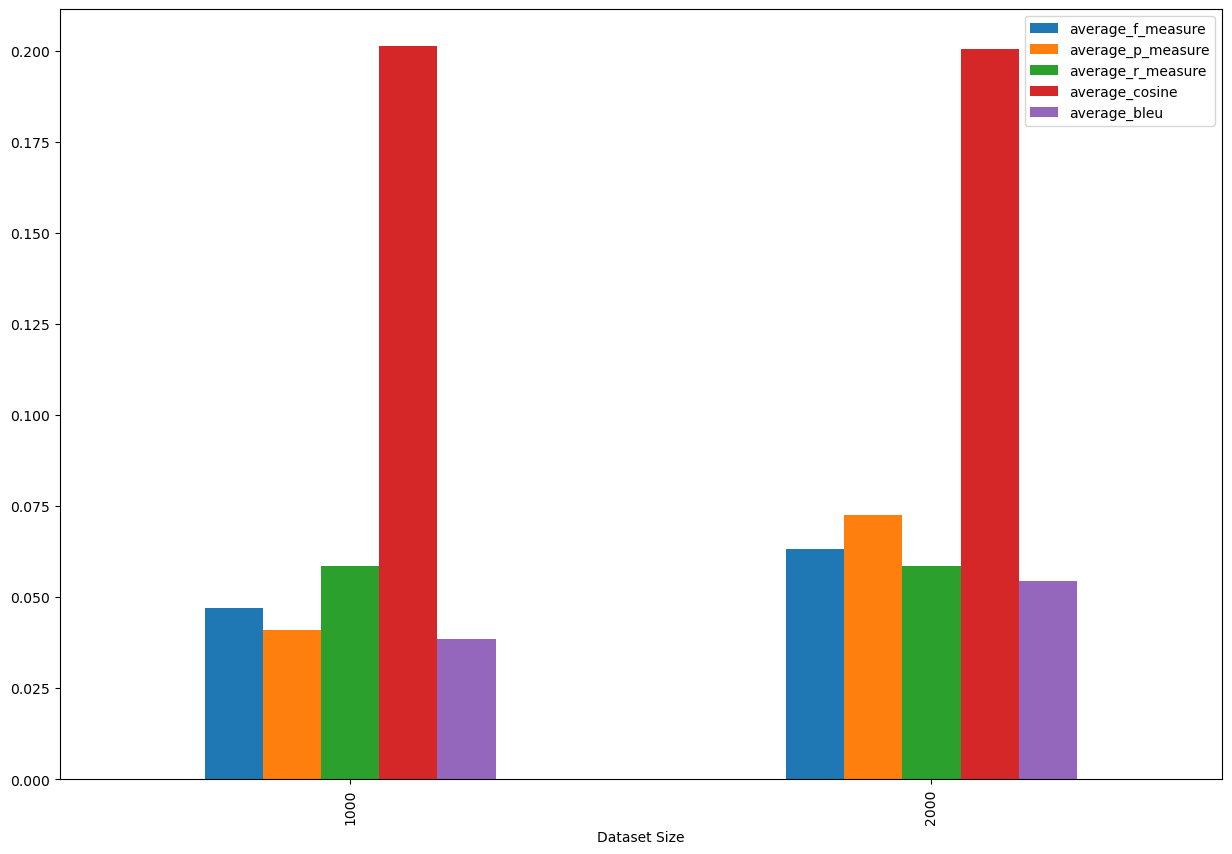

In [82]:
import matplotlib.pyplot as plot
from matplotlib.ticker import ScalarFormatter
#,figsize=(10,15)

table.plot.bar(x="Dataset Size",figsize=(15,10))
plot.show(block=True)

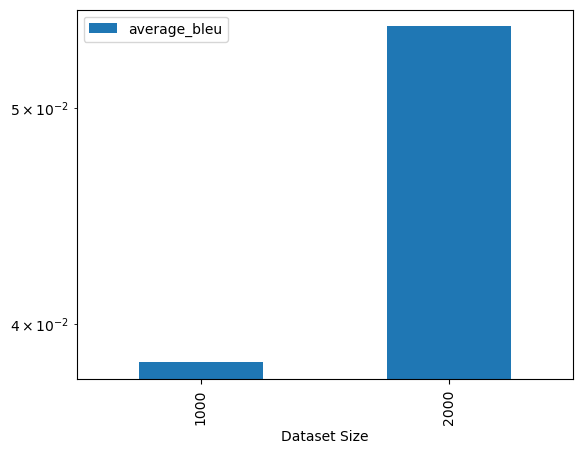

In [83]:
table.plot.bar(x="Dataset Size",y="average_bleu")
plot.yscale("log")
plot.gca().yaxis.set_major_formatter(ScalarFormatter())

plot.show(block=True)

### Save Performance Metrics

In [84]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y-%H:%M")
path= '../analytics/'+dt_string+".json"
table.to_json(r''+path,orient='records')


### Read Performance Metrics

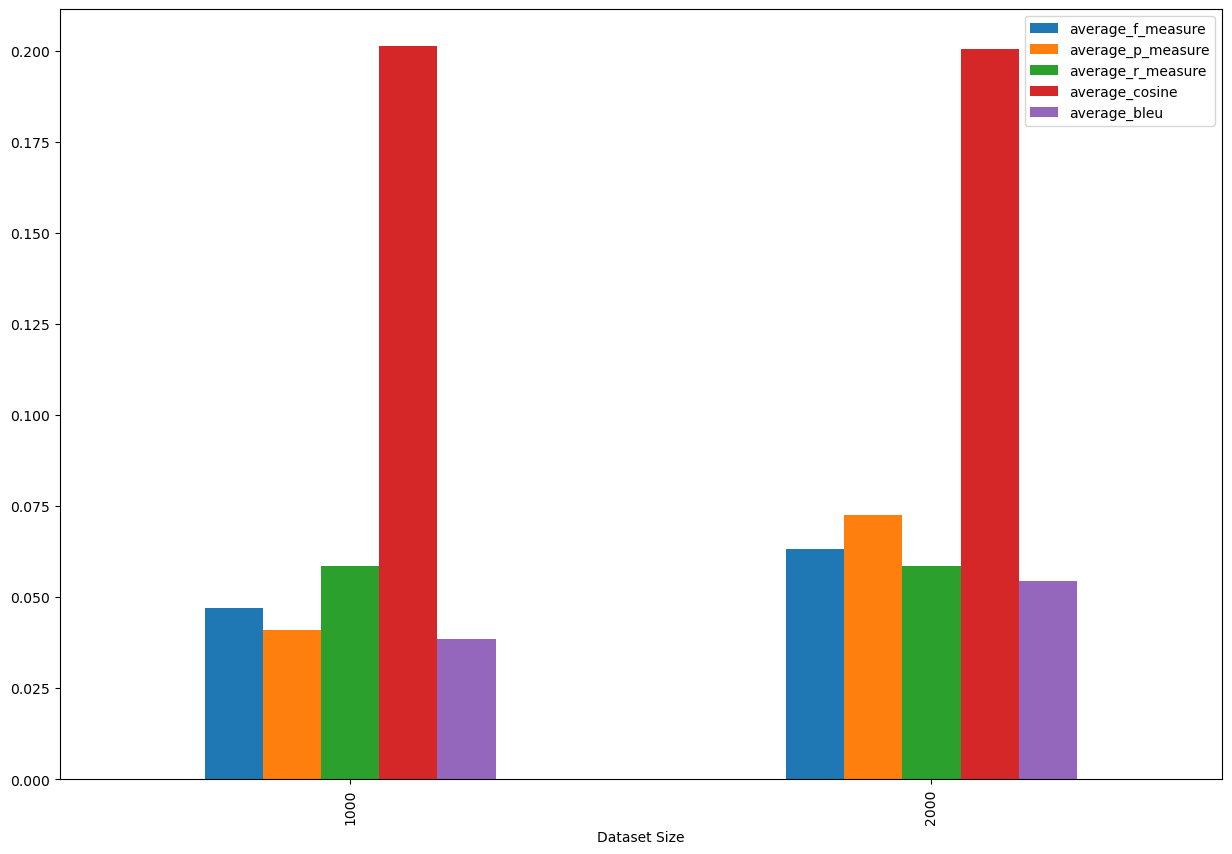

In [85]:
read_json=pd.read_json(path)

read_json.plot.bar(x="Dataset Size",figsize=(15,10))
plot.show(block=True)